Avec les mêmes données des post Python et R nous allons entrainer deux modèles des réseau de neurones
avec Keras et TensorFlow

# importation du dataset et conversion

In [1]:
import numpy as np
import pandas as pd

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str',
                    'Body': 'str', 'Title_raw': 'str', 'Text': 'str',
                    'Tags': 'str'}

nrows = 20000

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=dtypes_questions.keys(),
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=nrows
                          )


text_train, tag_train = df_questions.Text, df_questions.Tags

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# We create a tokenizer, configured to only take
# into account the top-1000 most common words
tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=33)
# This builds the word index
tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_matrix(text_train, mode='binary')
Y_train = tokenizer_Y.texts_to_matrix(tag_train, mode='binary')

X_train_padded = pad_sequences(X_train, padding="post")
Y_train_padded = pad_sequences(Y_train, padding="post")

label_len=len(Y_train_padded[0])

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

word_index_X = tokenizer_X.word_index
word_index_Y = tokenizer_Y.word_index

print('Found %s unique tokens in the posts.' % len(word_index_X))
print('Found %s unique tokens in the tags.' % len(word_index_Y))

Found 67021 unique tokens in the posts.
Found 2966 unique tokens in the tags.


In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='softmax'))

In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

In [6]:
history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=12,
                    batch_size=512,
                    validation_data=(X_val, Y_val))

Epoch 1/12
24/24 [==============================] - 2s 62ms/step - loss: 4.8236 - acc: 0.5981 - f1_m: 0.1267 - precision_m: 0.4566 - recall_m: 0.0837 - val_loss: 4.0272 - val_acc: 0.9200 - val_f1_m: 0.6182 - val_precision_m: 0.9525 - val_recall_m: 0.4576

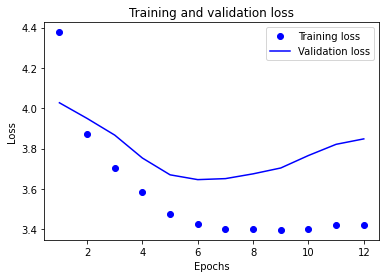

In [7]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 432x288 with 0 Axes>

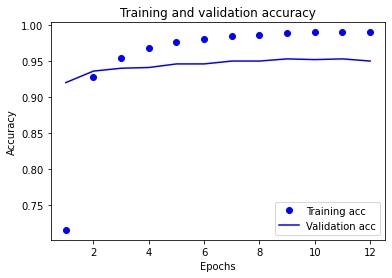

In [8]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [9]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)


Loss :  3.741102933883667
Accuracy :  0.9599999785423279
f1 Score :  0.7323662042617798
precision :  0.9656942486763
recall :  0.5912169218063354


In [10]:
# il faut trouver le moyen de redemarer le modele

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=8,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

Epoch 1/8
24/24 [==============================] - 1s 36ms/step - loss: 3.4301 - acc: 0.9900 - f1_m: 0.7528 - precision_m: 0.9950 - recall_m: 0.6055 - val_loss: 3.9133 - val_acc: 0.9500 - val_f1_m: 0.7158 - val_precision_m: 0.9570 - val_recall_m: 0.5718

In [11]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  4.221014499664307
Accuracy :  0.9570000171661377
f1 Score :  0.7298260927200317
precision :  0.9598979353904724
recall :  0.5898745656013489


In [12]:
print(word_index_Y)
Y_train_padded[0:3]

{'python': 1, 'r': 2, 'django': 3, 'ggplot2': 4, 'list': 5, 'numpy': 6, 'string': 7, 'dataframe': 8, 'x': 9, 'matplotlib': 10, '3': 11, '2': 12, 'data': 13, 'dictionary': 14, 'regex': 15, 'file': 16, 'pandas': 17, 'plot': 18, '7': 19, 'table': 20, 'dplyr': 21, 'datetime': 22, 'testing': 23, 'faq': 24, 'flask': 25, 'class': 26, 'sqlalchemy': 27, 'c': 28, 'function': 29, 'import': 30, 'performance': 31, 'windows': 32, 'models': 33, 'scipy': 34, 'exception': 35, 'arrays': 36, 'unicode': 37, 'unit': 38, 'csv': 39, 'markdown': 40, 'date': 41, 'sorting': 42, 'matrix': 43, 'variables': 44, 'shiny': 45, 'json': 46, 'io': 47, 'linux': 48, 'time': 49, 'module': 50, 'multithreading': 51, 'knitr': 52, 'image': 53, 'tkinter': 54, 'mysql': 55, 'memory': 56, 'formatting': 57, 'pip': 58, 'oop': 59, 'statistics': 60, 'rstudio': 61, 'package': 62, 'processing': 63, 'syntax': 64, 'algorithm': 65, 'virtualenv': 66, 'google': 67, 'logging': 68, 'line': 69, 'random': 70, 'parsing': 71, 'xml': 72, 'sql': 73,

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)

In [13]:
Y_predict = model.predict(partial_X_train)

In [14]:
np.argmax((Y_predict[0:3]>0.55).astype(int))

1

In [15]:
tag_train[0:3]

0    python aggregate pandas
1         r string uppercase
2       python python-import
Name: Tags, dtype: object

In [16]:
tokenizer_X.matrix_to_text((Y_predict[0:3]>0.55).astype(int))

AttributeError: 'Tokenizer' object has no attribute 'matrix_to_text'